### Base on TA's feedback, This notebook is going to demonstrate the performance of neutral network on our topic

In [34]:
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.utils import shuffle


In [35]:
# ===== 1) 读取数据 =====
DATA_PATH = "dataSet/heart.csv"   # 改成你的文件名
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# ===== 2) 基本检查 =====
expected = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS',
            'RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"missing column: {missing}")

y = df['HeartDisease'].astype(int) #

X = df.drop(columns=['HeartDisease']).copy()

# Turn string categorical value into value 
# Sex, ChestPain(0-3)(ATA, NAP, ASY, TA), RestingECG (0-2)(Normal, ST, LVH), ExerciseAngina (0-1)(Yes, NO), ST_Slope(0-2)(Up, Flat, Down)

# Sex: M/F -> 1/0
X['Sex'] = X['Sex'].str.strip().map({'M': 1, 'F': 0}).astype(int)

# ExerciseAngina: Y/N -> 1/0
X['ExerciseAngina'] = X['ExerciseAngina'].str.strip().map({'Y': 1, 'N': 0}).astype(int)

# chestpaintype
chestPainType = {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
X['ChestPainType'] = X['ChestPainType'].str.strip().map(chestPainType).astype(int)

# restingECG
restingECGType = {"Normal": 0, 'ST': 1, 'LVH': 2}
X['RestingECG'] = X['RestingECG'].str.strip().map(restingECGType).astype(int)

# st slope
slope = {'Up': 0, 'Flat': 1, 'Down': 2}
X['ST_Slope'] = X['ST_Slope'].str.strip().map(slope).astype(int)

# FastingBS make sure it is type int.
X['FastingBS'] = X['FastingBS'].astype(int)

print("✅ 数据清洗与编码完成")
print(f"X_encoded 形状: {X.shape}")
print(f"y 形状        : {y.shape}")
print(f"x type: {type(X)}")
print(f"Y type is : {type(y)}")



✅ 数据清洗与编码完成
X_encoded 形状: (918, 11)
y 形状        : (918,)
x type: <class 'pandas.core.frame.DataFrame'>
Y type is : <class 'pandas.core.series.Series'>


In [36]:
class HeartFailureNN(nn.Module):
    def __init__(self, input_features=11):
        super().__init__()
        self.fc1 = nn.Linear(input_features,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.2)
        
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
model = HeartFailureNN()
print(model)

HeartFailureNN(
  (fc1): Linear(in_features=11, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
def acc_recall_precision_F1(Yhat, Y):
    
    y = np.asarray(Y).ravel()
    yhat = np.asarray(Yhat).ravel()

    TP = np.sum((y == 1) & (yhat == 1))
    TN = np.sum((y == 0) & (yhat == 0))
    FP = np.sum((y == 0) & (yhat == 1))
    FN = np.sum((y == 1) & (yhat == 0))

    denom = TP + TN + FP + FN
    accuracy = (TP + TN) / denom if denom else 0.0

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0     # ← 修正
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

    return accuracy, recall, precision, F1


def confusion_matrix_display(yhat, y):
    # 把 labels 顺序设为 [1, 0]，第一行/列是正类=1
    cm = confusion_matrix(y_true=y, y_pred=yhat, labels=[1, 0])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Positive", "Negative"]  # 对应 [1, 0]
    )
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
    ax.set_title("Type I and Type II error graph")
    plt.tight_layout()
    plt.show()



def roc_auc_display(y_scores, y_true):
    auc = roc_auc_score(y_true, y_scores)
    print("AUC:", auc)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


def input_array_display(k, input_array=None, arrayname="array"):
    if not input_array:  # None 或 空列表
        print("Warning: input_array is empty.")
        return 0

    x = np.arange(1, k + 1)
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(x, input_array, edgecolor='black', alpha=0.8)

    ax.set_title(f"{k}-Fold {arrayname} Scores", fontsize=12, fontweight='bold')  # 移除未定义 featureSet
    ax.set_xlabel("Fold", fontsize=10)
    ax.set_ylabel(f"{arrayname} Score", fontsize=10)
    ax.set_xticks(x)
    ax.set_ylim(0, max(input_array) * 1.1 if max(input_array) > 0 else 1)

    ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=9)
    plt.tight_layout()
    plt.show()

In [38]:
def train_model(model, X_train, y_train, optimizer, criterion):
    model.train()

    # Forward
    optimizer.zero_grad()
    outputs = model(X_train)        # X: shape [N, D]
    loss = criterion(outputs, y_train)

    # Backward
    loss.backward()
    optimizer.step()

    # Accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train).sum().item()
    accuracy = correct / y_train.shape[0]
    print(f"Training accuracy: {accuracy:.4f}")

    return loss.item(), accuracy

@torch.no_grad()
def evaluate(model, X_val, y_val, criterion):
    model.eval()
    outputs = model(X_val)              # [N_val, num_classes]
    loss = criterion(outputs, y_val)

    probs = torch.softmax(outputs, dim=1)[:, 1]   # shape [N_val]

    _, predicted = torch.max(outputs, 1)          # shape [N_val]

    correct = (predicted == y_val).sum().item()
    accuracy = correct / y_val.shape[0]
    print(f"Validation accuracy: {accuracy:.4f}")

    return loss.item(), accuracy, predicted, probs


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)


Device: cuda
Fold 1
Training accuracy: 0.4605
Validation accuracy: 0.5815
Training accuracy: 0.5409
Validation accuracy: 0.5380
Training accuracy: 0.5245
Validation accuracy: 0.5815
Training accuracy: 0.5422
Validation accuracy: 0.5815
Training accuracy: 0.5259
Validation accuracy: 0.5815
Training accuracy: 0.5245
Validation accuracy: 0.5815
Training accuracy: 0.5422
Validation accuracy: 0.5815
Training accuracy: 0.5381
Validation accuracy: 0.5815
Training accuracy: 0.5327
Validation accuracy: 0.5815
Training accuracy: 0.5681
Validation accuracy: 0.5815
Training accuracy: 0.5654
Validation accuracy: 0.5815
Training accuracy: 0.5436
Validation accuracy: 0.5815
Training accuracy: 0.5559
Validation accuracy: 0.5815
Training accuracy: 0.5613
Validation accuracy: 0.5815
Training accuracy: 0.5531
Validation accuracy: 0.5815
Training accuracy: 0.5845
Validation accuracy: 0.5815
Training accuracy: 0.5668
Validation accuracy: 0.5815
Training accuracy: 0.5531
Validation accuracy: 0.5815
Training

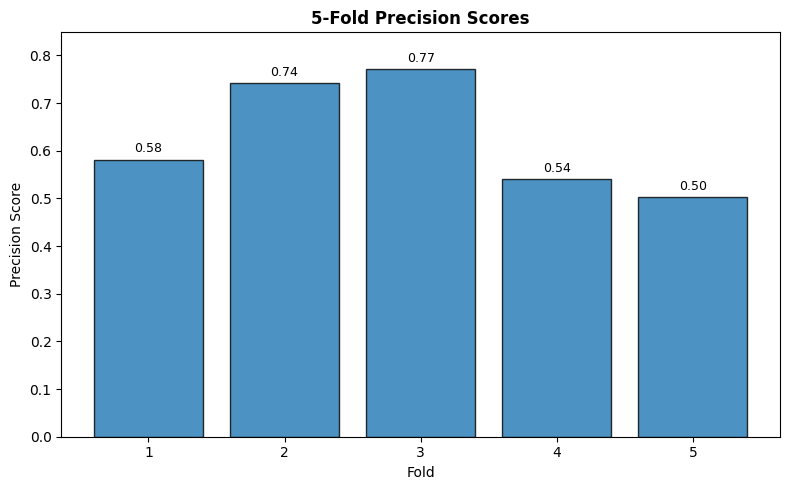

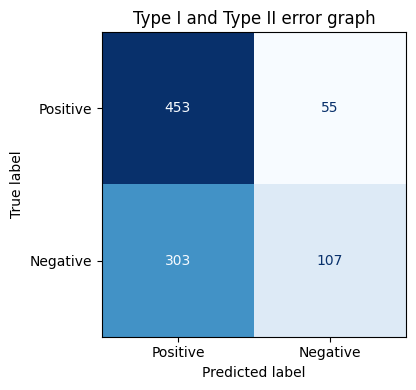

AUC: 0.6597464951027464


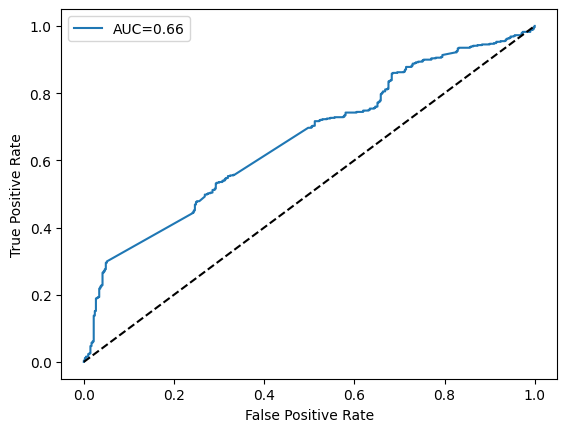

===== K-Fold Cross Validation Results =====
Accuracy : 0.6098
Recall   : 0.8897
Precision: 0.6279
F1-score : 0.7130


In [40]:
epochs = 50
k = 5
kf = KFold(k, shuffle=True,random_state=42)
Accuracy_list, Recall_list, Precision_list, F1_score_list = [], [], [], []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
all_y_true = []
all_y_pred = []
all_y_score = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train_df = X.iloc[train_idx]
    y_train_sr = y.iloc[train_idx]
    X_val_df   = X.iloc[val_idx]
    y_val_sr   = y.iloc[val_idx]
    X_train_t = torch.tensor(X_train_df.values, dtype=torch.float32, device=device)
    y_train_t = torch.tensor(y_train_sr.values, dtype=torch.long, device=device)
    X_val_t = torch.tensor(X_val_df.values, dtype=torch.float32, device=device)
    y_val_t = torch.tensor(y_val_sr.values, dtype=torch.long, device=device)
    model = HeartFailureNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    print(f"Fold {fold+1}")
    
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model, X_train_t, y_train_t, optimizer, criterion)
        val_loss, val_acc, _, _ = evaluate(model, X_val_t, y_val_t, criterion)
    _, _, final_pred, final_probs = evaluate(model, X_val_t, y_val_t, criterion)
    
    y_true = y_val_t.cpu().numpy()
    yhat   = final_pred.cpu().numpy()
    yscore = final_probs.cpu().numpy()

    accuracy_val, recall_val, precision_val, F1_val = acc_recall_precision_F1(yhat, y_true)
    
    all_y_true.extend(y_true.tolist())
    all_y_pred.extend(yhat.tolist())
    all_y_score.extend(yscore.tolist())

    Accuracy_list.append(accuracy_val)
    Recall_list.append(recall_val)
    Precision_list.append(precision_val)
    F1_score_list.append(F1_val)


input_array_display(k, Precision_list, "Precision")
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_score = np.array(all_y_score)

confusion_matrix_display(all_y_pred, all_y_true)
roc_auc_display(all_y_score, all_y_true)

# 返回各指标均值
mean_acc = float(np.mean(Accuracy_list))
mean_recall = float(np.mean(Recall_list))
mean_precision = float(np.mean(Precision_list))
mean_f1 = float(np.mean(F1_score_list))

print("===== K-Fold Cross Validation Results =====")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Recall   : {mean_recall:.4f}")
print(f"Precision: {mean_precision:.4f}")
print(f"F1-score : {mean_f1:.4f}")
print("============================================")
